# Turbine operation flags

This example demonstrates how to run a wind farm simulation with given operational flags, that indicate if turbines are switched on or off at each state. There is more than one way for achieving this within `foxes`, but here we will make use of the `OpFlagController` which was specifically added for this purpose.

These are the imports that we will need:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV
import foxes.constants as FC

We first generate the input data, starting with three simple wind states:

In [2]:
sdata = pd.DataFrame(
    {
        FV.WS: [10, 10, 10],
        FV.WD: [270, 270, 90],
    }
)
sdata.index.name = FC.STATE
sdata

,WS,WD
state,,
0,10,270
1,10,270
2,10,90


The spatially uniform states based on this data are created by

In [3]:
states = foxes.input.states.StatesTable(
    sdata,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    fixed_vars={FV.TI: 0.05, FV.RHO: 1.225},
)

We consider a simple row of turbines as our wind farm:

In [4]:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_row(
    farm=farm,
    xy_base=[0.0, 0.0],
    xy_step=[800.0, 0.0],
    n_turbines=3,
    turbine_models=["DTU10MW"],
    verbosity=0,
)

Now let's create the operational flag for the 3 states and 3 turbines:

In [5]:
odata = xr.Dataset(
    {
        FV.OPERATING: (
            (FC.STATE, FC.TURBINE),
            np.array(
                [
                    [1, 1, 1],
                    [0, 1, 1],
                    [0, 0, 1],
                ],
                dtype=bool,
            ),
        )
    }
)
odata[FV.OPERATING].values

array([[ True,  True,  True],
       [False,  True,  True],
       [False, False,  True]])

We now create the `OpFlagController` based on this data, and select it when creating the algorithm object:

In [6]:
mbook = foxes.ModelBook()
mbook.farm_controllers["op_cntrl"] = foxes.models.farm_controllers.OpFlagController(
    odata
)

In [7]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    wake_models=["Bastankhah2014_linear_lim_k004"],
    farm_controller="op_cntrl",
    mbook=mbook,
)

We can now calculate the farm results:

In [8]:
farm_results = algo.calc_farm()
farm_results.to_dataframe()[[FV.WD, FV.AMB_REWS, FV.REWS, FV.CT, FV.P, FV.OPERATING]]

Initializing model 'StatesTable'

Initializing algorithm 'Downwind'

------------------------------------------------------------
  Algorithm: Downwind
  Running Downwind: calc_farm
------------------------------------------------------------
  n_states : 3
  n_turbines: 3
------------------------------------------------------------
  states    : StatesTable()
  rotor     : CentreRotor()
  controller: OpFlagController()
  wake frame: RotorWD()
  deflection: NoDeflection()
------------------------------------------------------------
  wakes:
    0) Bastankhah2014_linear_lim_k004: Bastankhah2014(ws_linear_lim, induction=Madsen, k=0.04)
------------------------------------------------------------
  partial wakes:
    0) Bastankhah2014_linear_lim_k004: axiwake6, PartialAxiwake(n=6)
------------------------------------------------------------
  turbine models:
    0) DTU10MW: PCtFile(D=178.3, H=119.0, P_nominal=10000.0, P_unit=kW, rho=1.225, var_ws_ct=REWS2, var_ws_P=REWS3)
----------------

WD  AMB_REWS       REWS        CT            P  operating
state turbine                                                              
0     0        270.0      10.0  10.000000  0.814000  7286.500000       True
      1        270.0      10.0   7.637441  0.829953  3286.710475       True
      2        270.0      10.0   6.958701  0.859900  2465.899141       True
1     0        270.0      10.0  10.000000  0.000000     0.000000      False
      1        270.0      10.0  10.000000  0.814000  7286.500000       True
      2        270.0      10.0   7.637441  0.829953  3286.710475       True
2     0         90.0      10.0   8.778113  0.000000     0.000000      False
      1         90.0      10.0   7.637441  0.000000     0.000000      False
      2         90.0      10.0  10.000000  0.814000  7286.500000       True

Indeed the power and ct values are zero for non-operating turbines. In fact the turbine type and all other turbine models are not evaluated at all for those turbines. The non-operating values for the variables are zero for `FV.P` and `FV.CT` and `np.nan` for the rest. This choices can be overloaded by passing a dictionary for the parameter `non_op_values` in the constructor of the `OpFlagController` class.

One way of visualizing the power pattern for all states and turbines is the `StateTurbineMap`, indicating the zero power results for the switched-off turbines:

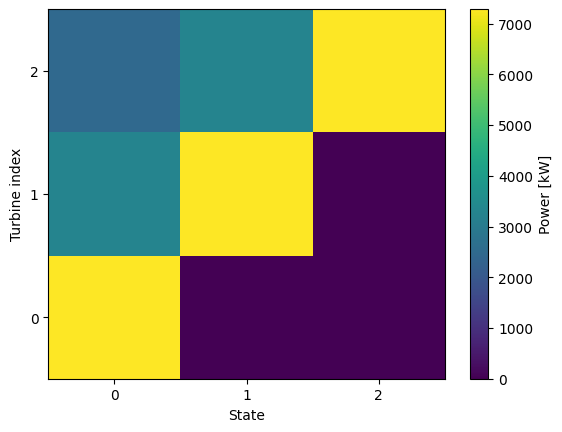

In [9]:
o = foxes.output.StateTurbineMap(farm_results)
ax = o.plot_map(FV.P, cbar_label="Power [kW]")

Finally, let's look at the flow fields of the three states. The non-operating turbines do not contribute to the wakes:

DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating data at 30401 points for 3 states


ProcessEngine: Computing 45 chunks using 15 workers


  0%|                                                                                                   | 0/45 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 9434.35it/s]

ProcessEngine: Completed all 45 chunks



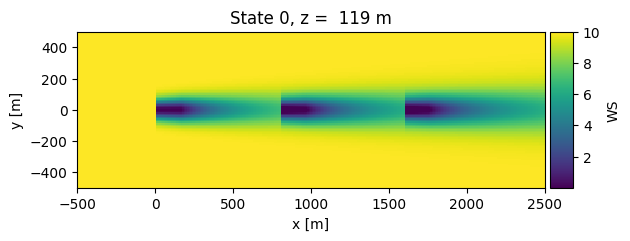

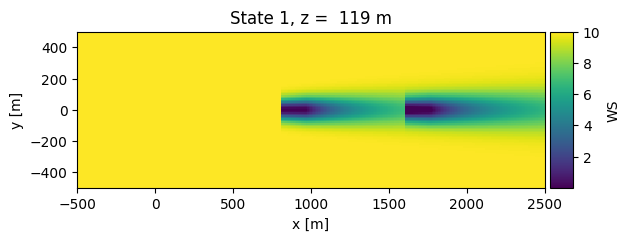

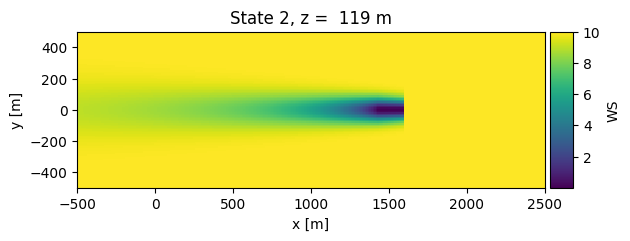

In [10]:
o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_xy(FV.WS, resolution=10, xmin=-500, xmax=2500, verbosity=0)
for fig in g:
    plt.show()